In [1]:
%matplotlib inline
import yt
import yt.fields.vector_operations
from yt.units import dimensions, kboltz, mp
import os, sys, glob, errno
import matplotlib as mpl
#mpl.use("agg")
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import Locator
from scipy.interpolate import spline
import operator
import h5py
import mag_initialize as m


mu = 0.588
mu_e = 1.14
gamma = 5/3

a=20

def get_units(L):
    temp_str = str(L[-1:])
    k = temp_str.rfind("]") + 2
    return temp_str[k:]

def density(filename,groupname):
    return m.yt.YTArray.from_hdf5(filename, dataset_name="/%s/density_mean"%groupname)[a:]  

def kT(filename,groupname):
    return m.yt.YTArray.from_hdf5(filename, dataset_name="/%s/kT_mean"%groupname)[a:] 

# radial 
def velocity_r_variance(filename,groupname):
    v_r_stddev=m.yt.YTArray.from_hdf5(filename, dataset_name="/%s/velocity_spherical_radius_stddev"%groupname)[a:] 
    return v_r_stddev**2

# tangential
def velocity_t_variance(filename,groupname):
    v_theta_stddev=m.yt.YTArray.from_hdf5(filename, dataset_name="/%s/velocity_spherical_theta_stddev"%groupname)[a:] 
    v_phi_stddev=m.yt.YTArray.from_hdf5(filename, dataset_name="/%s/velocity_spherical_phi_stddev"%groupname)[a:]  
    return v_theta_stddev**2+v_phi_stddev**2

# filename is HDF5 file, groupname is 0500_profiles
def velocity_variance(filename,groupname):
    #v_r_stddev=m.yt.YTArray.from_hdf5(filename, dataset_name="/%s/velocity_spherical_radius_stddev"%groupname)
    #v_t_stddev=m.yt.YTArray.from_hdf5(filename, dataset_name="/%s/velocity_spherical_theta_stddev"%groupname)
    #v_p_stddev=m.yt.YTArray.from_hdf5(filename, dataset_name="/%s/velocity_spherical_phi_stddev"%groupname)    
    return velocity_r_variance(filename,groupname)+velocity_t_variance(filename,groupname)

# filename is HDF5 file, groupname is 0500_profiles
def mag_field_variance(filename,groupname):
    B_r_stddev=m.yt.YTArray.from_hdf5(filename, dataset_name="/%s/magnetic_field_spherical_radius_stddev"%groupname)[a:] 
    B_t_stddev=m.yt.YTArray.from_hdf5(filename, dataset_name="/%s/magnetic_field_spherical_theta_stddev"%groupname)[a:] 
    B_p_stddev=m.yt.YTArray.from_hdf5(filename, dataset_name="/%s/magnetic_field_spherical_phi_stddev"%groupname)[a:]     
    return B_r_stddev**2+B_t_stddev**2+B_p_stddev**2

# mean squared
def velocity_mean_sq(filename,groupname):
    v_r_mean=m.yt.YTArray.from_hdf5(filename, dataset_name="/%s/velocity_spherical_radius_mean"%groupname)[a:] 
    v_t_mean=m.yt.YTArray.from_hdf5(filename, dataset_name="/%s/velocity_spherical_theta_mean"%groupname)[a:] 
    v_p_mean=m.yt.YTArray.from_hdf5(filename, dataset_name="/%s/velocity_spherical_phi_mean"%groupname)[a:]     
    return v_r_mean**2+v_t_mean**2+v_p_mean**2

# mean squared
def mag_field_mean_sq(filename,groupname):
    B_r_mean=m.yt.YTArray.from_hdf5(filename, dataset_name="/%s/magnetic_field_spherical_radius_mean"%groupname)[a:] 
    B_t_mean=m.yt.YTArray.from_hdf5(filename, dataset_name="/%s/magnetic_field_spherical_theta_mean"%groupname)[a:] 
    B_p_mean=m.yt.YTArray.from_hdf5(filename, dataset_name="/%s/magnetic_field_spherical_phi_mean"%groupname)[a:]     
    return B_r_mean**2+B_t_mean**2+B_p_mean**2

# sound speed sq
def c_s_sq(filename,groupname):
    return gamma*kT(filename,groupname)/(mu*mp)

# Alfven speed sq
def v_A_sq(filename,groupname):
    return (mag_field_variance(filename,groupname)+mag_field_mean_sq(filename,groupname))/(4*np.pi*density(filename,groupname))
    
def n_e(filename,groupname):
    return density(filename,groupname)/(mu_e*mp)
    
def S(filename,groupname):
    return kT(filename,groupname)/(n_e(filename,groupname))**(2/3)

def entropy(filename,groupname):
    entropy=m.yt.YTArray.from_hdf5(filename, dataset_name="/%s/entropy_mean"%groupname)[a:] 
    return entropy

def hopefully_constant(filename,groupname):
    B_sq = (mag_field_variance(filename,groupname)+mag_field_mean_sq(filename,groupname))
    return B_sq/(density(filename,groupname))**(4/3)

/data/odin/BACKUPS/jzuhone/miniconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)
/home/jzuhone/Source/yt/yt/fields/local_fields.py:46: UserWarning: Because 'sampling_type' not specified, yt will assume a cell 'sampling_type'
  warnings.warn("Because 'sampling_type' not specified, yt will "


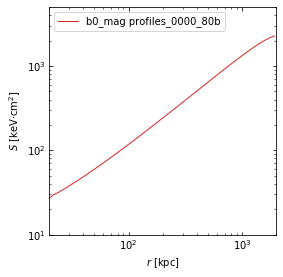

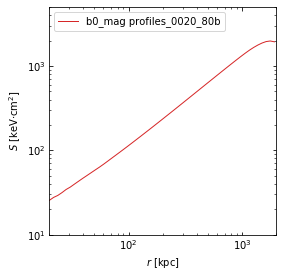

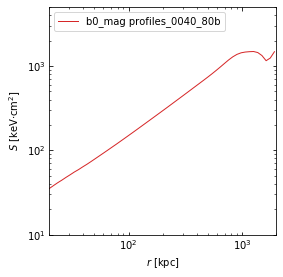

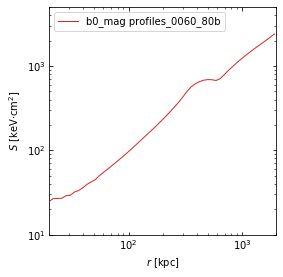

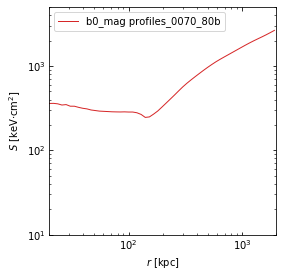

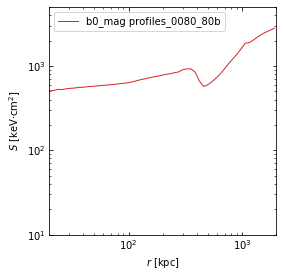

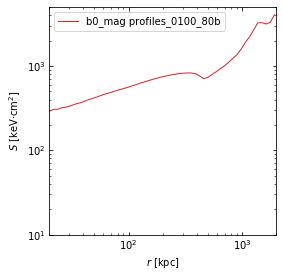

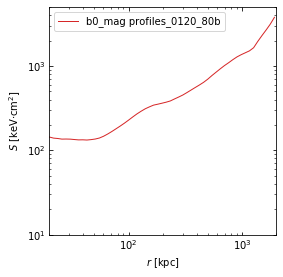

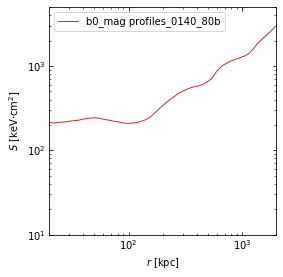

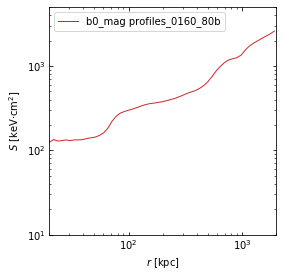

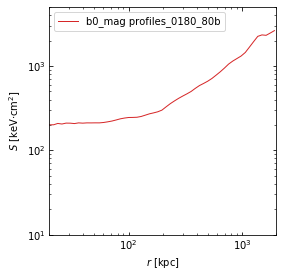

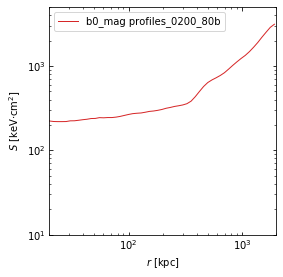

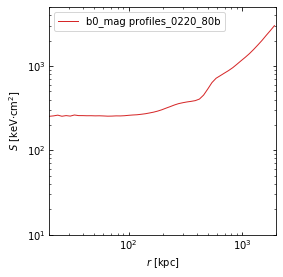

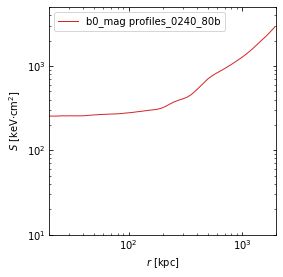

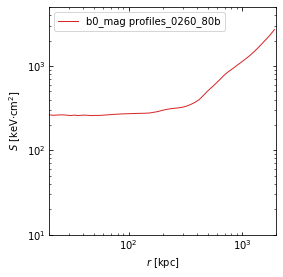

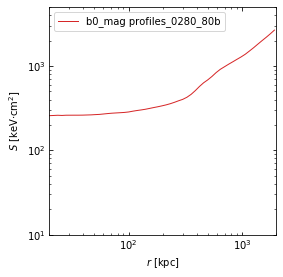

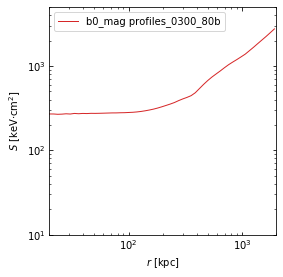

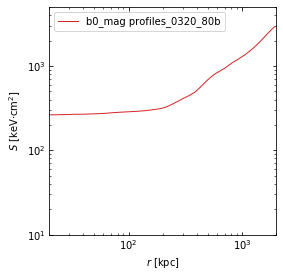

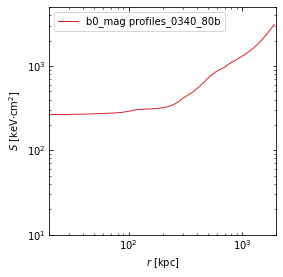

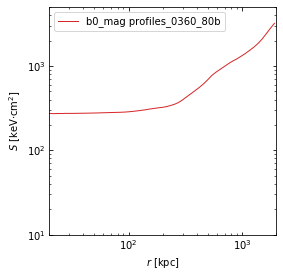

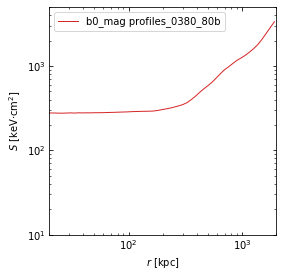

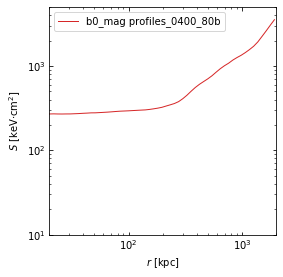

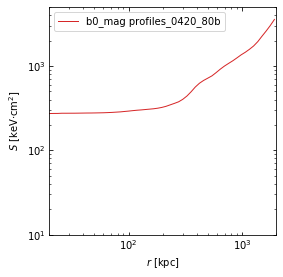

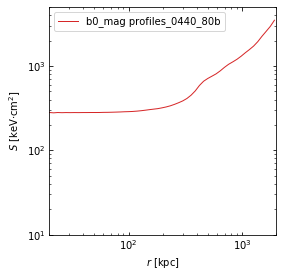

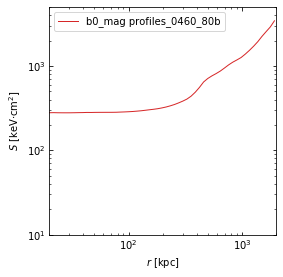

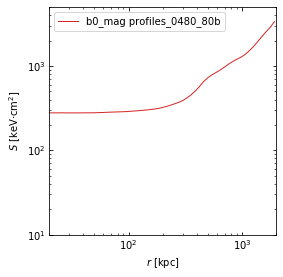

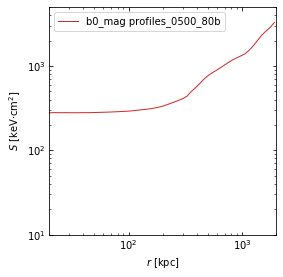

In [3]:
SIM_TYPE11 = "1to1_b0"
SIM_TYPE12 = "1to1_b0.5"
SIM_TYPE13 = "1to1_b1"
SIM_TYPE21 = "1to3_b0"
SIM_TYPE22 = "1to3_b0.5"
SIM_TYPE23 = "1to3_b1"
SIM_TYPE31 = "1to10_b0"
SIM_TYPE32 = "1to10_b0.5"
SIM_TYPE33 = "1to10_b1"

SIM_TYPE11_mag = "1to1_b0"+"_mag.hdf5"
SIM_TYPE12_mag = "1to1_b0.5"+"_mag.hdf5"
SIM_TYPE13_mag = "1to1_b1"+"_mag.hdf5"

SIM_TYPE21_mag = "1to3_b0"+"_mag.hdf5"
SIM_TYPE22_mag = "1to3_b0.5"+"_mag.hdf5"
SIM_TYPE23_mag = "1to3_b1"+"_mag.hdf5"

SIM_TYPE31_mag = "1to10_b0"+"_mag.hdf5"
SIM_TYPE32_mag = "1to10_b0.5"+"_mag.hdf5"
SIM_TYPE33_mag = "1to10_b1"+"_mag.hdf5"

SIM_TYPE11_no_mag = "1to1_b0"+"_no_mag.hdf5"
SIM_TYPE12_no_mag = "1to1_b0.5"+"_no_mag.hdf5"
SIM_TYPE13_no_mag = "1to1_b1"+"_no_mag.hdf5"

SIM_TYPE21_no_mag = "1to3_b0"+"_no_mag.hdf5"
SIM_TYPE22_no_mag = "1to3_b0.5"+"_no_mag.hdf5"
SIM_TYPE23_no_mag = "1to3_b1"+"_no_mag.hdf5"

SIM_TYPE31_no_mag = "1to10_b0"+"_no_mag.hdf5"
SIM_TYPE32_no_mag = "1to10_b0.5"+"_no_mag.hdf5"
SIM_TYPE33_no_mag = "1to10_b1"+"_no_mag.hdf5"

radius = m.yt.YTArray.from_hdf5(SIM_TYPE11_mag, dataset_name="/%s/radius"%"profiles_0000_80b")[a:].in_units('kpc')

fn = h5py.File(SIM_TYPE11_mag, 'r')
keys=list(fn.keys())
fn.close()

for p in keys:
    if 'profiles' in p and '80b' in p:

        m.plt.close('all')
        f = m.plt.figure()
        m.plt.figure(figsize=(4, 4))
        #plt.subplots_adjust(hspace=0.001)

        xlim1=2e1
        xlim2=2e3
        ylim1=1e1
        ylim2=5e3
        num=(m.np.log10(xlim2)-m.np.log10(xlim1))/(m.np.log10(ylim2)-m.np.log10(ylim1))



        ax1 = m.plt.subplot(111, aspect=num)
        #ax1.tick_params(direction='in',top='on',right='on')


        axes = [ax1]

        # magnetic
        try:
            line_11_mag, =ax1.plot(radius, entropy(SIM_TYPE11_mag,p), 'C3', lw=1, label="b0_mag %s" % p)
        except Exception as error:
            print("%s didn't work" %p)
        
        ax1.legend(handles=[line_11_mag], loc=2)

        #format axes
        for plot_ax in axes:
            plot_ax.tick_params(axis='both',
                            which='both',
                            direction='in',
                            bottom='on',
                            top='on',
                            left='on',
                            right='on')

            plot_ax.set_ylabel("$S$ [keV$\cdot$cm$^2$]") #% get_units(S(SIM_TYPE11_mag,p)))

            plot_ax.set_xscale('log')
            plot_ax.set_yscale('log')
            plot_ax.set_xlim(xlim1,xlim2)
            plot_ax.set_ylim(ylim1,ylim2)

            plot_ax.set_xlabel("$r$ [kpc]")

            #plot_ax.set_xlim(0.0, 10000.0)
        #ax1.set_ylabel("testLABEL")
        #ax1.set_title('Time Series (%s)')
        m.plt.tight_layout()
        m.plt.savefig("entropy_profiles_t/%s_%s" %('1to1_b0',p))
        m.plt.show()

KeyError: "Unable to open object (Object 'entropy_mean' doesn't exist)"

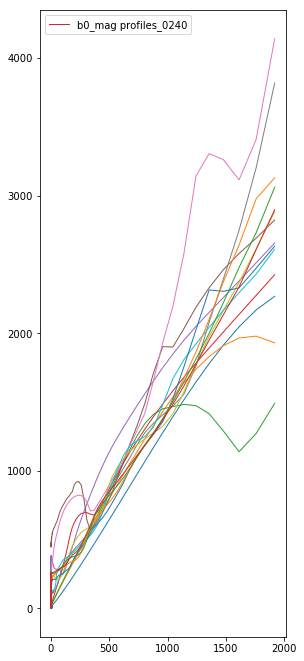

In [19]:
SIM_TYPE11 = "1to1_b0"
SIM_TYPE12 = "1to1_b0.5"
SIM_TYPE13 = "1to1_b1"
SIM_TYPE21 = "1to3_b0"
SIM_TYPE22 = "1to3_b0.5"
SIM_TYPE23 = "1to3_b1"
SIM_TYPE31 = "1to10_b0"
SIM_TYPE32 = "1to10_b0.5"
SIM_TYPE33 = "1to10_b1"

SIM_TYPE11_mag = "1to1_b0"+"_mag.hdf5"
SIM_TYPE12_mag = "1to1_b0.5"+"_mag.hdf5"
SIM_TYPE13_mag = "1to1_b1"+"_mag.hdf5"

SIM_TYPE21_mag = "1to3_b0"+"_mag.hdf5"
SIM_TYPE22_mag = "1to3_b0.5"+"_mag.hdf5"
SIM_TYPE23_mag = "1to3_b1"+"_mag.hdf5"

SIM_TYPE31_mag = "1to10_b0"+"_mag.hdf5"
SIM_TYPE32_mag = "1to10_b0.5"+"_mag.hdf5"
SIM_TYPE33_mag = "1to10_b1"+"_mag.hdf5"

SIM_TYPE11_no_mag = "1to1_b0"+"_no_mag.hdf5"
SIM_TYPE12_no_mag = "1to1_b0.5"+"_no_mag.hdf5"
SIM_TYPE13_no_mag = "1to1_b1"+"_no_mag.hdf5"

SIM_TYPE21_no_mag = "1to3_b0"+"_no_mag.hdf5"
SIM_TYPE22_no_mag = "1to3_b0.5"+"_no_mag.hdf5"
SIM_TYPE23_no_mag = "1to3_b1"+"_no_mag.hdf5"

SIM_TYPE31_no_mag = "1to10_b0"+"_no_mag.hdf5"
SIM_TYPE32_no_mag = "1to10_b0.5"+"_no_mag.hdf5"
SIM_TYPE33_no_mag = "1to10_b1"+"_no_mag.hdf5"

radius = m.yt.YTArray.from_hdf5(SIM_TYPE23_mag, dataset_name="/%s/radius"%"profiles_0000")[a:].in_units('kpc')

fn = h5py.File(SIM_TYPE11_mag, 'r')
keys=list(fn.keys())
fn.close()

m.plt.close('all')
f = m.plt.figure()
m.plt.figure(figsize=(15, 20))

xlim1=2e1
xlim2=2e3
ylim1=1e2
ylim2=5e3
num=(m.np.log10(xlim2)-m.np.log10(xlim1))/(m.np.log10(ylim2)-m.np.log10(ylim1))
ax1 = m.plt.subplot(131, aspect=num)
#ax1.tick_params(direction='in',top='on',right='on')
axes = [ax1]

for p in keys:
    if 'profiles' in p:


        # magnetic
        line_11_mag, =ax1.plot(radius, entropy(SIM_TYPE11_mag,p), lw=1, label="b0_mag %s" % p)
        # non-magnetic
        
        ax1.legend(handles=[line_11_mag], loc=2)

#format axes
for plot_ax in axes:
    plot_ax.tick_params(axis='both',
                    which='both',
                    direction='in',
                    bottom='on',
                    top='on',
                    left='on',
                    right='on')

    plot_ax.set_ylabel("$S$ [keV$\cdot$cm$^2$]") #% get_units(S(SIM_TYPE11_mag,p)))

    plot_ax.set_xscale('log')
    plot_ax.set_yscale('log')
    plot_ax.set_xlim(xlim1,xlim2)
    plot_ax.set_ylim(ylim1,ylim2)

    plot_ax.set_xlabel("$r$ [kpc]")

            #plot_ax.set_xlim(0.0, 10000.0)
        #ax1.set_ylabel("testLABEL")
        #ax1.set_title('Time Series (%s)')
m.plt.tight_layout()
m.plt.show()